# An Implemetation of TensorFlow Eager Execution [Tutorial](www.tensorflow.org/get_started/eager)

## What does eager execution do?
Eager execution makes TensorFlow evaluate operations immediately, returns concrete values instead of creating a computational graph.  
Using computational graphs is messy, in my opinion.

## Let's set up the eager mode

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

print("TensorFlow version : {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

/Users/Yang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version : 1.8.0
Eager execution: True


##  Now let's solve the Iris classification problem

### 1 Import the dataset

##### 1.1 Download

In [7]:
# train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

# train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url),
#                                           origin = train_dataset_url)
# directly downloaded from tensorflow.org
train_dataset_filepath = '/Users/Yang/Documents/iris_training.csv'
print("local copy of the csv: {}".format(train_dataset_filepath))

local copy of the csv: /Users/Yang/Documents/iris_training.csv


##### 1.2 Inspect

In [8]:
!head -n5 {train_dataset_filepath}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


##### 1.3 Parse

Purpose: parse the features and label values into a format that Python model can use.

In [6]:
def parse_csv(line):
    example_defaults = [[0.],[0.],[0.],[0.],[0]]
    parse_line = tf.decode_csv(line, example_defaults)
    features = tf.reshape(parse_line[:-1], shape = (4,))
    label = tf.reshape(parse_line[-1], shape = ())
    return features, label

##### 1.4 Create training tf.data.Dataset

In [26]:
train_dataset = tf.data.TextLineDataset(train_dataset_filepath) # what format?
train_dataset = train_dataset.skip(1) # skip header row
train_dataset = train_dataset.map(parse_csv) # parse each line. (how?)
train_dataset = train_dataset.shuffle(buffer_size = 1000) # shuffle 
train_dataset = train_dataset.batch(32) # create batch

features, label = iter(train_dataset).next()
print("example feature: ", features[1])
print("example label: ",label[1])

example feature:  tf.Tensor([7.2 3.  5.8 1.6], shape=(4,), dtype=float32)
example label:  tf.Tensor(2, shape=(), dtype=int32)


In [23]:
print(train_dataset)

<BatchDataset shapes: ((?, 4), (?,)), types: (tf.float32, tf.int32)>


### 2 Select the type of model

##### 2.0 What is a model?
A model is the _relationship_ between features and the label. How philosophical!  

Our features:
* sepal length
* sepal width
* petal length
* petal width  

Our label:
* 0, 1, or 2

##### 2.1 Select a model
We choose a fully connected neural network with 2 hidden layers.

##### 2.2 Create the model using Keras

In [54]:
# try your best to construct the model independently :P

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = 'relu', input_shape = (4,)),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(3)
])

In [31]:
# print out the variables of this model
print(model.variables)

[<tf.Variable 'dense_3/kernel:0' shape=(4, 10) dtype=float32, numpy=
array([[ 0.5381404 ,  0.18437058, -0.01535481,  0.2799598 ,  0.56598306,
         0.17062527, -0.60801584, -0.48325843, -0.42263946, -0.54941314],
       [-0.43457735, -0.6414499 , -0.1040563 , -0.07607806, -0.06715333,
        -0.04583162, -0.0518291 ,  0.14967448, -0.08538568, -0.62853265],
       [-0.64046896,  0.58321047,  0.11024261,  0.33452123,  0.39841628,
        -0.02003199, -0.22981626,  0.05149239, -0.32473025, -0.4023718 ],
       [ 0.10289353,  0.02996922, -0.02211159,  0.20018435,  0.08619076,
         0.05010343, -0.13881052,  0.583742  , -0.27357623,  0.6040765 ]],
      dtype=float32)>, <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'dense_4/kernel:0' shape=(10, 10) dtype=float32, numpy=
array([[ 0.5101551 , -0.3347029 ,  0.40614772,  0.4989996 ,  0.5229714 ,
         0.22498721, -0.37687427, -0.4771697 ,  0

### 3 Train the model

Purpose: to learn enough about the structures of training dataset to make predictions

##### 3.1 Define loss and gradient function

In [35]:
def loss(model, x, y):
    y_ = model(x) # predicted label
    return tf.losses.sparse_softmax_cross_entropy(labels = y, logits = y_)

def grad(model, inputs, targets):
    
    # grad is the amount that variables of model should change
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [63]:
for x,y in train_dataset:
    print(x)
    print(y)
    print(grad(model, x, y))
    print(loss(model,x,y))

tf.Tensor(
[[5.7 3.  4.2 1.2]
 [7.7 2.8 6.7 2. ]
 [6.8 3.2 5.9 2.3]
 [6.2 3.4 5.4 2.3]
 [6.3 3.3 4.7 1.6]
 [5.7 2.8 4.1 1.3]
 [4.4 3.  1.3 0.2]
 [6.7 3.  5.2 2.3]
 [6.9 3.1 5.1 2.3]
 [7.7 2.6 6.9 2.3]
 [6.1 3.  4.9 1.8]
 [6.4 2.8 5.6 2.2]
 [5.1 2.5 3.  1.1]
 [5.  3.4 1.6 0.4]
 [4.7 3.2 1.6 0.2]
 [5.4 3.  4.5 1.5]
 [6.2 2.2 4.5 1.5]
 [5.  3.5 1.6 0.6]
 [7.  3.2 4.7 1.4]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.5 0.3]
 [6.  2.2 5.  1.5]
 [5.8 2.7 5.1 1.9]
 [5.7 2.9 4.2 1.3]
 [4.9 3.  1.4 0.2]
 [5.2 2.7 3.9 1.4]
 [6.3 3.4 5.6 2.4]
 [4.6 3.4 1.4 0.3]
 [4.9 3.1 1.5 0.1]
 [5.6 2.9 3.6 1.3]
 [5.8 2.8 5.1 2.4]], shape=(32, 4), dtype=float32)
tf.Tensor([1 2 2 2 1 1 0 2 2 2 2 2 1 0 0 1 1 0 1 0 0 0 2 2 1 0 1 2 0 0 1 2], shape=(32,), dtype=int32)
[<tf.Tensor: id=535081, shape=(4, 10), dtype=float32, numpy=
array([[-0.06764118,  0.19622953,  0.43736628,  0.        ,  0.04959953,
         0.        ,  0.        , -0.37953776,  0.        ,  0.15018803],
       [-0.02845677,  0.08070314,  0.1

##### 3.2 Create an optimizer

In [33]:
# stochastic gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)

##### 3.3 Training loop

In [55]:

# keep results for plotting
train_loss = []
train_accuracy = []

num_epoches = 201

for epoch in range(num_epoches):
    
    # I knew tfe.metrics only after writing this code
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    # training loop, batches of 32
    for x, y in train_dataset:
        
        # optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                 global_step = tf.train.get_or_create_global_step())
        
        # track progress
        epoch_loss_avg(loss(model, x, y))
        epoch_accuracy(tf.argmax(model(x), axis = 1, output_type = tf.int32), y)
    
    train_loss.append(epoch_loss_avg.result())
    train_accuracy.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                   epoch_loss_avg.result(),
                                                                   epoch_accuracy.result()))

Epoch 000: Loss: 1.261, Accuracy: 33.333%
Epoch 050: Loss: 0.484, Accuracy: 88.333%
Epoch 100: Loss: 0.271, Accuracy: 95.000%
Epoch 150: Loss: 0.192, Accuracy: 97.500%
Epoch 200: Loss: 0.138, Accuracy: 98.333%


In [48]:
print(epoch_loss_avg.result())

tf.Tensor(0.08862022962421179, shape=(), dtype=float64)


##### 3.4 Visualize loss function over time

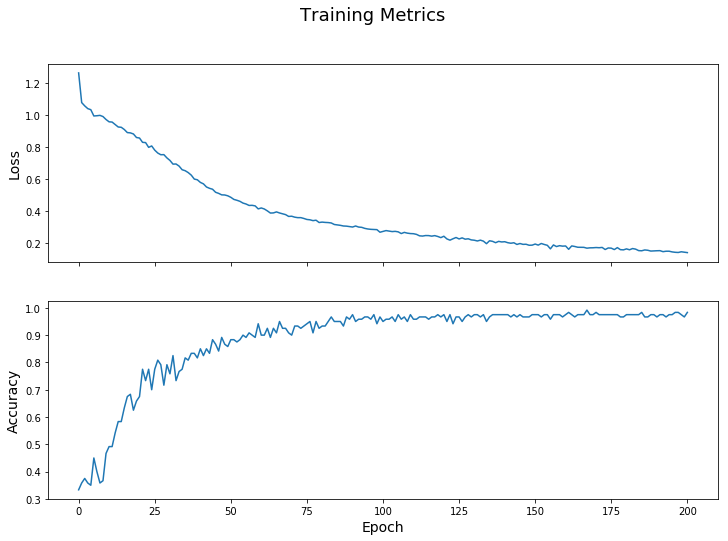

In [58]:
fig, axes = plt.subplots(2, sharex = True, figsize = (12,8))

fig.suptitle('Training Metrics', fontsize = 18)

axes[0].set_ylabel('Loss', fontsize = 14)
axes[0].plot(train_loss)

axes[1].set_ylabel('Accuracy', fontsize = 14)
axes[1].set_xlabel('Epoch', fontsize = 14)
axes[1].plot(train_accuracy)

plt.show()

### 4 Evaluate the model's effectiveness

##### 4.1 Setup the test dataset

In [62]:
test_dataset_filepath = '/Users/Yang/Documents/iris_test.csv'

test_dataset = tf.data.TextLineDataset(test_dataset_filepath)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

##### 4.2 Evaluate the model on the test dataset

In [69]:
test_accuracy = tfe.metrics.Accuracy()

for x,y in test_dataset:
    predictions = tf.argmax(model(x), axis = 1, output_type = tf.int32)
    test_accuracy(predictions, y)

print("Test Accuracy: {:.3%}".format(test_accuracy.result()))

Test Accuracy: 96.667%


### 5 Use the trained model to make predictions

In [75]:
class_ids = ["Iris setosa","Iris versicolor","Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 5.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1,]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_index = tf.argmax(logits).numpy()
    name = class_ids[class_index]
    print("Example {}, prediction: {}".format(i, name))

Example 0, prediction: Iris setosa
Example 1, prediction: Iris versicolor
Example 2, prediction: Iris virginica
